In [ ]:
!pip3 install requests skimpy csaps shap pygam numpy==1.23.5

In [ ]:
!pip3 install lightgbm catboost

In [ ]:
!git clone https://github.com/ustunb/risk-slim
!pip install -e ./risk-slim 		# install in editable mode  

In [1]:
import requests
def githubimport(user, repo, module):
   d = {}
   url = 'https://raw.githubusercontent.com/{}/{}/master/{}.py'.format(user, repo, module)
   r = requests.get(url).text
   exec(r, d)
   return d

# get repository

medical_explainer = githubimport('giangntgg', 'Uni-ACS', 'medical_explainer')
medical_explainer_classic = githubimport('giangntgg', 'Uni-ACS', 'medical_explainer_classic')

In [2]:
import pandas as pd 
from skimpy import skim

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

import riskslim

from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?


#Summary of the paper 

Clinical scores are the most popularly used metrics to stratify clinical outcomes and risks for patients. The classical clinical score is aggregated via a logistic regression model using several manually selected features. On the other hand, clinical models utilising machine learning could predict patients outcome with much higher power, but they are not as interpretable and do not translate to a single score like the classical clinical score. 

The paper aimed to translate clinical machine learning model predictions (such as predictions of heart failures, kidney failures and sepsis during surgery) to an interpretable and risk stratifying clinical score – an equivalent yet possibly more powerful score compared to the classical clinical score. 

The approach taken by the paper Unified Auto Clinical Scoring (“Uni-ACS”) was to use SHapley Additive exPlanations (SHAP) – a popular model interpretability method – that was able to solve the following issues of the classical risk score aggregation.

###Claims to verify 
* Uni-ACS approach have higher predictive power compared to Risk SLIM and baseline classical clinical scores across the dataset chosen.

* Machine learning and logistic regression performance dropped after converting to a clinical score. 

* The converted clinical score is correlated to the explanation of feature relationships to output in the ML models. 


#Descriptive Analysis

In [3]:
path = 'https://raw.githubusercontent.com/giangntgg/Uni-ACS/main/mimiciv_sepsis_mortality/mimiciv_sepsis.csv'

df = pd.read_csv(path)

In [4]:
df.head()

,testtrain,hadm_id,icu_adm_flag,hosdeath_flag,gender,marital_status,ethnicity,insurance,myocardial_infarct,congestive_heart_failure,...,fbc24hr_mchc_first,fbc24hr_mcv_first,fbc24hr_platelet_first,fbc24hr_rbc_first,fbc24hr_rdw_first,fbc24hr_wbc_first,chem24hr_aniongap_first,chem24hr_bun_first,chem24hr_chloride_first,chem24hr_glucose_first
0,Train,20000057,0,0,F,SINGLE,WHITE,Medicare,0,0,...,33.2,98.0,154,3.93,13.3,8.4,19,19,102,77
1,Train,20001947,0,0,F,SINGLE,HISPANIC/LATINO,Other,0,0,...,32.6,87.0,414,3.30,13.8,13.1,13,10,103,286
2,Train,20002712,0,1,F,WIDOWED,WHITE,Medicare,0,1,...,32.8,89.0,355,3.24,14.4,12.0,11,11,100,79
3,Train,20004718,0,1,F,MARRIED,WHITE,Medicare,0,0,...,29.3,93.0,454,3.11,24.6,16.3,18,46,112,122
4,Train,20005333,0,0,M,WIDOWED,WHITE,Medicare,0,0,...,32.6,90.0,187,4.89,16.0,7.5,18,21,99,202


In [6]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7690   │ │ int64       │ 64    │                                                          │
│ │ Number of columns │ 88     │ │ float64     │ 18    │                                                          │
│ └───────────────────┴────────┘ │ string      │ 6     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name          ┃ NA ┃ NA % ┃ mean     ┃ sd      ┃ p0       ┃ p25      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ hadm_id              │  0 │    0 │ 25000000 │ 2900000 │ 20000000 │ 22000000 │ 27000000 │ 30000000 │ ██████ │  │
│ │ icu_adm_flag         │  0 │    0 │     0.27 │    0.44 │        0 │        0 │        1 │        1 │ █    ▃ │  │
│ │ hosdeath_flag        │  0 │    0 │     0.07 │    0.25 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ myocardial_infarct   │  0 │    0 │    0.093 │    0.29 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ congestive_heart_fai │  0 │    0 │     0.23 │    0.42 │        0 │        0 │        0 │        1 │ █    ▂ │  │
│ │ peripheral_vascular_ │  0 │    0 │    0.076 │    0.26 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ cerebrovascular_dise │  0 │    0 │     0.08 │    0.27 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ dementia             │  0 │    0 │    0.049 │    0.22 │        0 │        0 │        0 │        1 │   █    │  │
│ │ chronic_pulmonary_di │  0 │    0 │     0.28 │    0.45 │        0 │        0 │        1 │        1 │ █    ▃ │  │
│ │ rheumatic_disease    │  0 │    0 │    0.045 │    0.21 │        0 │        0 │        0 │        1 │   █    │  │
│ │ peptic_ulcer_disease │  0 │    0 │    0.015 │    0.12 │        0 │        0 │        0 │        1 │   █    │  │
│ │ mild_liver_disease   │  0 │    0 │     0.11 │    0.31 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ diabetes_without_cc  │  0 │    0 │     0.24 │    0.42 │        0 │        0 │        0 │        1 │ █    ▂ │  │
│ │ diabetes_with_cc     │  0 │    0 │    0.074 │    0.26 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ paraplegia           │  0 │    0 │    0.024 │    0.15 │        0 │        0 │        0 │        1 │   █    │  │
│ │ renal_disease        │  0 │    0 │     0.24 │    0.43 │        0 │        0 │        0 │        1 │ █    ▃ │  │
│ │ malignant_cancer     │  0 │    0 │     0.15 │    0.35 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ severe_liver_disease │  0 │    0 │    0.042 │     0.2 │        0 │        0 │        0 │        1 │   █    │  │
│ │ metastatic_solid_tum │  0 │    0 │    0.074 │    0.26 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ aids                 │  0 │    0 │    0.011 │    0.11 │        0 │        0 │        0 │        1 │   █    │  │
│ │ admflag_last1yr      │  0 │    0 │     0.15 │    0.35 │        0 │        0 │        0 │        1 │ █    ▁ │  │
│ │ time2bg_24hr_flag    │  0 │    0 │     0.16 │    0.3

#Methodology and Experiments Run

The experiments would utilise the medical_explainer function to apply on different machine learning models on the MIMIC-III Sepsis dataset. Different models would take in the same features and to predict xxx. Hyperparameters for these models (except for ablation studies on LightGBM and CatBoost) would be following the suggested hyperparameters by the paper for reproducibility.  

* Performance in terms of AUROC and AUC-PR before medical_explainer would be recorded
* Performance in terms of AUROC and AUC-PR after the medical_explainer applied would be recorded
* Performance drop/increase would be calculated 
* Finally, the feature relationships to the targeted variables would be studied. 


##Utilities Function

In [5]:
def performance(y_true, y_pred):
  roc_auc = roc_auc_score(y_true, y_pred)
  print("ROC AUC: " + str(roc_auc))
  
  average_precision = average_precision_score(y_true, y_pred)
  print("Average Precision: " + str(average_precision))

In [6]:
df = df.drop(['testtrain', 'hadm_id'], axis=1)

df['gender'] = (df['gender'] == 'M').astype(int)

df = pd.concat([df, pd.get_dummies(df['marital_status'], prefix='marital_status')], axis=1)
df = df.drop(['marital_status'], axis=1)

df = pd.concat([df, pd.get_dummies(df['ethnicity'], prefix='ethnicity')], axis=1)
df = df.drop(['ethnicity'], axis=1)

df = pd.concat([df, pd.get_dummies(df['insurance'], prefix='insurance')], axis=1)
df = df.drop(['insurance'], axis=1)

df = pd.concat([df, pd.get_dummies(df['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
df = df.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

seed = 7

X = df.drop(columns = ['icu_adm_flag', 'hosdeath_flag'])
y = df['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


##1. Baseline

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)

In [10]:
# Select top 10 features for fair comparison
top_n = 10

scaler = MinMaxScaler()
select = SelectKBest(chi2, k=top_n)
select.fit(scaler.fit_transform(X_train), y_train)
selected_features = select.get_feature_names_out(X_train.columns)

| Step 1 ==> Selecting top n features
| Step 2 ==> Transforming features based on GAM
| Step 3 ==> Fitting logistic regression model on transformed categories
| Step 4 ==> Calibrating logistic regression model


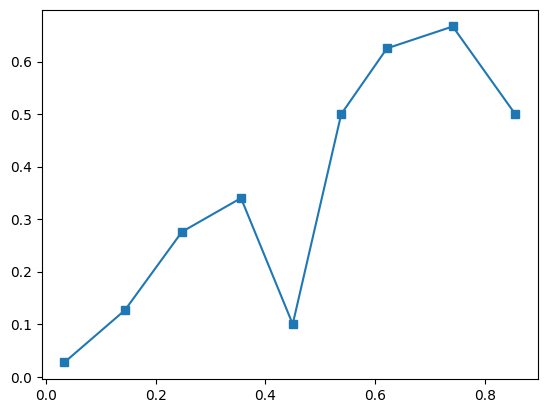

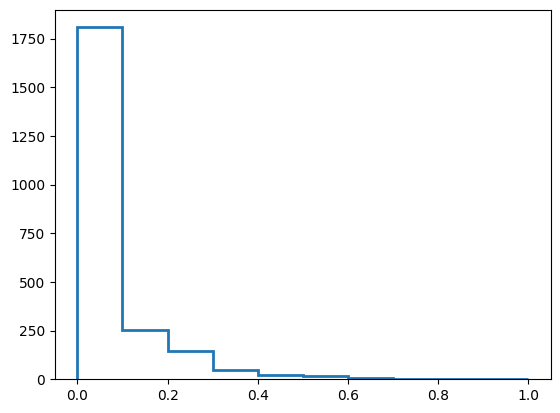

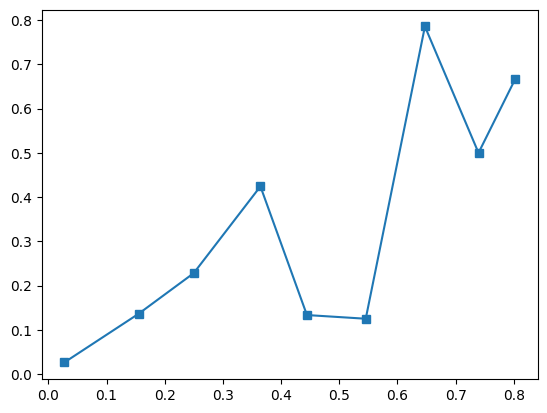

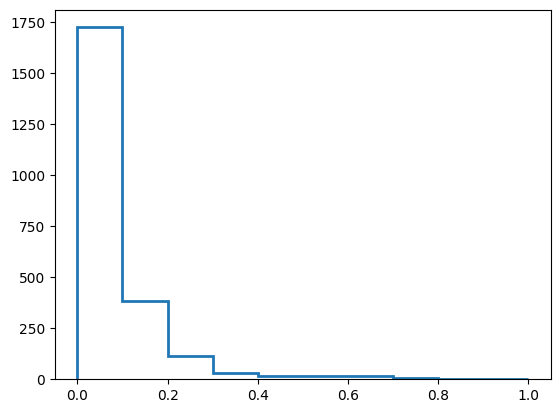

| Step 5 ==> Fit clinical score calculator
Fit clincal score calculator
Threshold:0.1
4

Threshold:0.5
9

Threshold:0.9
14

ROC AUC: 0.8313183232113761
Average Precision: 0.27039558169085587


In [11]:
from pygam import s, f

equation = s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9)

explainer = medical_explainer_classic['explainer'](X_train, y_train, X_test, y_test)

# ----------- Move this to medical_explainer_classic_
from sklearn.model_selection import StratifiedKFold

print('| Step 1 ==> Selecting top n features')
explainer.selected_features = selected_features

print('| Step 2 ==> Transforming features based on GAM')
explainer.find_features_categories_gam(equation)

print('| Step 3 ==> Fitting logistic regression model on transformed categories')
explainer.fit_logreg()

print('| Step 4 ==> Calibrating logistic regression model')

skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

explainer.plot_calibration_original()
explainer.calibrate(cv=skf)
explainer.plot_calibration_calibrated()

print('| Step 5 ==> Fit clinical score calculator')
explainer.fit_calculator()
# ----------- Move this to medical_explainer_classic_

_, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

##2. RiskSLIM

In [12]:
y_train = y_train.reset_index(drop=True)
top_n = 10
scaler = MinMaxScaler()
kbest = SelectKBest(chi2, k=top_n)
scaler.fit(X_train)

X_train = kbest.fit_transform(scaler.transform(X_train), y_train)
X_test = kbest.transform(scaler.transform(X_test))

X_train = pd.DataFrame(X_train, columns=X.columns[kbest.get_support()])
X_test = pd.DataFrame(X_test, columns=X.columns[kbest.get_support()])

X_train.insert(0, 'hosdeath_flag', y_train)
X_train.to_csv('data_train.csv', index=False)

sample_weights_csv_file = None                              # csv file of sample weights for the dataset (optional)

# problem parameters
max_coefficient = 5                                         # value of largest/smallest coefficient
max_L0_value = 5                                            # maximum model size (set as float(inf))
max_offset = 50                                             # maximum value of offset parameter (optional)
c0_value = 1e-6                                             # L0-penalty parameter such that c0_value > 0; larger values -> sparser models; we set to a small value (1e-6) so that we get a model with      max_L0_value terms

In [13]:
data_csv_file = 'data_train.csv'

# load data from disk
data = riskslim.load_data_from_csv(dataset_csv_file = data_csv_file, sample_weights_csv_file = sample_weights_csv_file)

# create coefficient set and set the value of the offset parameter
coef_set = riskslim.CoefficientSet(variable_names = data['variable_names'], lb = -max_coefficient, ub = max_coefficient, sign = 0)
coef_set.update_intercept_bounds(X = data['X'], y = data['Y'], max_offset = max_offset)

constraints = {
    'L0_min': 0,
    'L0_max': max_L0_value,
    'coef_set':coef_set,
}
 
# major settings (see riskslim_ex_02_complete for full set of options)
settings = {
    # Problem Parameters
    'c0_value': c0_value,
    #
    # LCPA Settings
    'max_runtime': 30.0,                               # max runtime for LCPA
    'max_tolerance': np.finfo('float').eps,             # tolerance to stop LCPA (set to 0 to return provably optimal solution)
    'display_cplex_progress': True,                     # print CPLEX progress on screen
    'loss_computation': 'fast',                         # how to compute the loss function ('normal','fast','lookup')
    #
    # LCPA Improvements
    'round_flag': True,                                # round continuous solutions with SeqRd
    'polish_flag': True,                               # polish integer feasible solutions with DCD
    'chained_updates_flag': True,                      # use chained updates
    'add_cuts_at_heuristic_solutions': True,            # add cuts at integer feasible solutions found using polishing/rounding
    #
    # Initialization
    'initialization_flag': True,                       # use initialization procedure
    'init_max_runtime': 120.0,                         # max time to run CPA in initialization procedure
    'init_max_coefficient_gap': 0.49,
    #
    # CPLEX Solver Parameters
    'cplex_randomseed': 0,                              # random seed
    'cplex_mipemphasis': 0,                             # cplex MIP strategy
}

# train model using lattice_cpa
model_info, mip_info, lcpa_info = riskslim.run_lattice_cpa(data, constraints, settings)

#print model contains model
riskslim.print_model(model_info['solution'], data)


def predict_df(X, rho):
    rho_values = np.copy(rho)
    
    if len(rho) > len(X.columns):
        intercept = rho[0]
        rho_values = np.delete(rho_values, 0)
    else:
        intercept = 0
        
    scores = np.dot(X.values, rho_values)
    probs = 1/(1+np.exp(-(intercept + scores)))
    predictions = (probs >= 0.5).astype(int)
    
    return scores, probs, predictions

_, probs, _ = predict_df(X_test, model_info['solution'])
performance(y_test, probs)

setting c0_value = 0.0 for (Intercept) to ensure that intercept is not penalized
04/25/23 @ 11:33 AM | switching loss computation from fast to lookup
04/25/23 @ 11:33 AM | 201 rows in lookup table
04/25/23 @ 11:33 AM | ------------------------------------------------------------
04/25/23 @ 11:33 AM | runnning initialization procedure
04/25/23 @ 11:33 AM | ------------------------------------------------------------
04/25/23 @ 11:33 AM | CPA produced 2 cuts
04/25/23 @ 11:33 AM | running naive rounding on 6 solutions
04/25/23 @ 11:33 AM | best objective value: 0.4002
04/25/23 @ 11:33 AM | rounding produced 5 integer solutions
04/25/23 @ 11:33 AM | best objective value is 0.3711
04/25/23 @ 11:33 AM | running sequential rounding on 6 solutions
04/25/23 @ 11:33 AM | best objective value: 0.4002
04/25/23 @ 11:33 AM | sequential rounding produced 5 integer solutions
04/25/23 @ 11:33 AM | best objective value: 0.3373
04/25/23 @ 11:33 AM | polishing 10 solutions
04/25/23 @ 11:33 AM | best objec

Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
         Disabling repeat represolve because of lazy constraint/incumbent callback.
Tried aggregator 1 time.
Reduced MIP has 22 rows, 24 columns, and 63 nonzeros.
Reduced MIP has 10 binaries, 12 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.03 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)
04/25/23 @ 11:33 AM | adding 201 initial cuts

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variable B NodeID Parent  Depth

      0     0        0.2045    22                      0.2045  

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)

##3. Logistic Regression 

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)

| Step 1  ==> Calibrating model


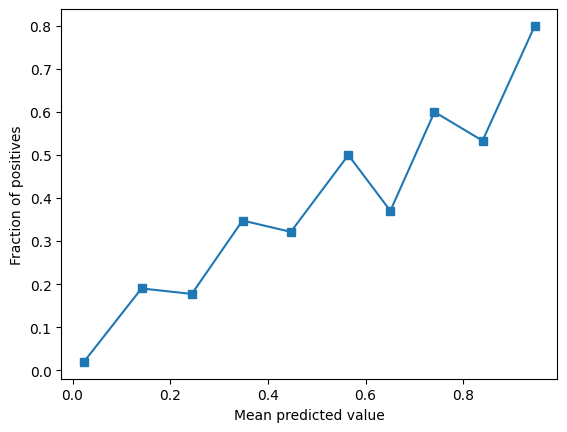

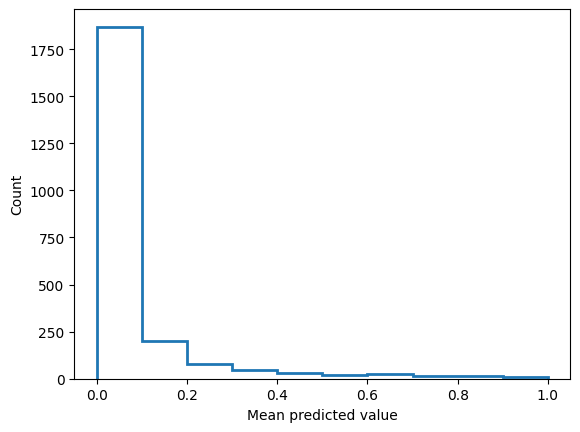

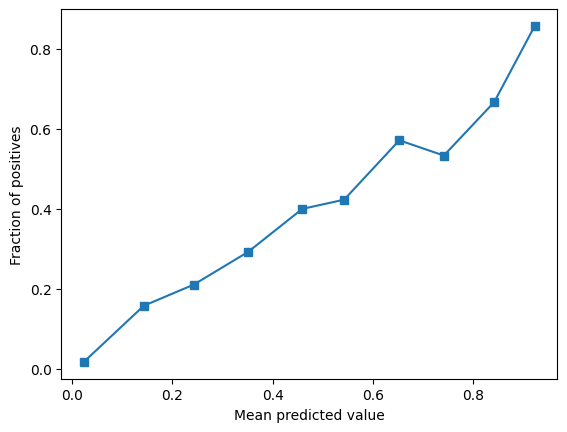

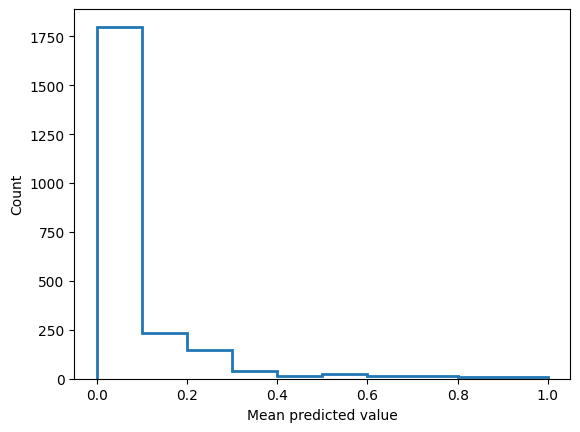

ROC AUC: 0.8820026662716635
Average Precision: 0.4157228149040318
Accuracy: 0.9332466406588643
ROC AUC: 0.8821522737372243
Average Precision: 0.41497050858011847
Accuracy: 0.9349804941482445

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 54.0

Probability threshold: 0.5
Score threshold: 76.0

Probability threshold: 0.9
Score threshold: 80.0

ROC AUC: 0.784291216116131
Average Precision: 0.21323205161025488


In [8]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='linear', method='novel')
scores, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

In [9]:
features = np.argpartition(np.abs(clf[1].coef_), -2)[0][-2:]

print(clf[1].coef_[0][features])

# PartialDependenceDisplay.from_estimator(clf, X_test, features)

print(np.corrcoef(scores, X_test.iloc[:, features[0]]))
print(np.corrcoef(scores, X_test.iloc[:, features[1]]))

[ 0.84150179 -1.08864336]
[[ 1.         -0.22992522]
 [-0.22992522  1.        ]]
[[ 1.         -0.29622485]
 [-0.29622485  1.        ]]


##4. Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    'n_estimators': [60, 80, 120, 140], 
    'max_depth':[1, 3, 5]
}

GBoost = GradientBoostingClassifier(random_state=seed)
clf = GridSearchCV(GBoost, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 3, 'n_estimators': 120}
0.8778901449427765


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=120, max_depth=3, random_state=seed).fit(X_train, y_train)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

ROC AUC: 0.9018871278329137
Average Precision: 0.4494568415623149


| Step 1  ==> Calibrating model


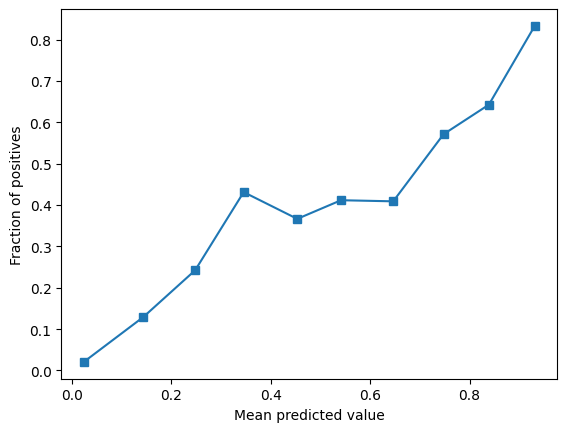

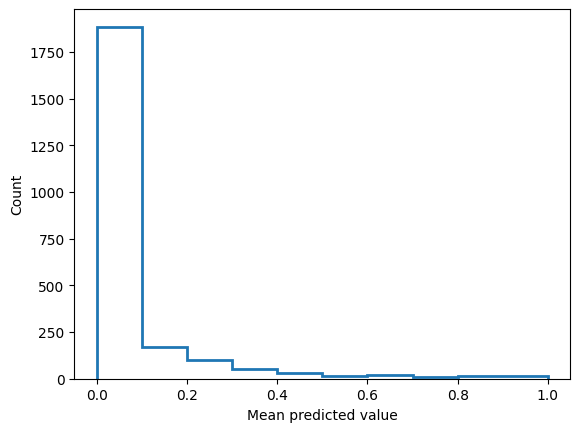

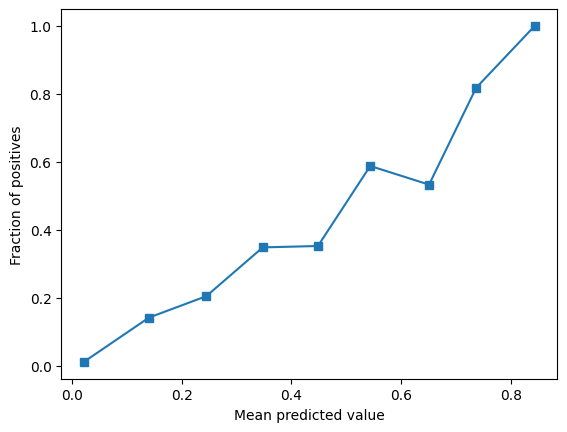

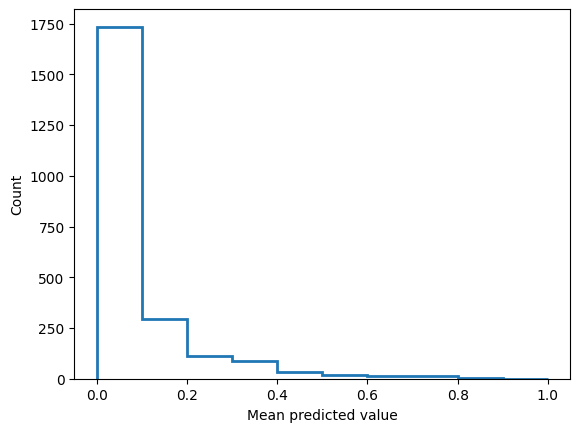

ROC AUC: 0.9018871278329137
Average Precision: 0.4494568415623149
Accuracy: 0.9345470307758994
ROC AUC: 0.9033565397718857
Average Precision: 0.44654566647180516
Accuracy: 0.9375812743823146

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 1064.0

Probability threshold: 0.5
Score threshold: 1930.0

Probability threshold: 0.9
Score threshold: 1985.0

ROC AUC: 0.8674492667752925
Average Precision: 0.34576926540645847


In [11]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)
scores, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

[[1.         0.42048177]
 [0.42048177 1.        ]]
[[1.        0.6827811]
 [0.6827811 1.       ]]


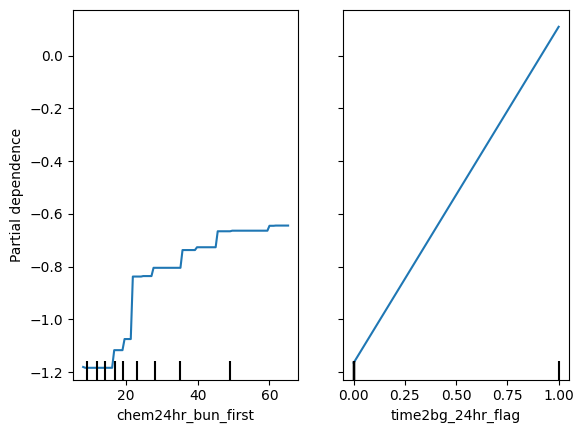

In [12]:
features = np.argpartition(clf.feature_importances_, -2)[-2:]

PartialDependenceDisplay.from_estimator(clf, X_test, features)

print(np.corrcoef(scores, X_test.iloc[:, features[0]]))
print(np.corrcoef(scores, X_test.iloc[:, features[1]]))

##5. Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators': [260, 280, 300, 320], 
    'max_depth':[1, 3, 5]
}

RanFor = RandomForestClassifier(n_estimators=110, max_depth=7, random_state=seed)
clf = GridSearchCV(RanFor, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 5, 'n_estimators': 260}
0.8751310443942021


In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=260, max_depth=5, random_state=seed)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

ROC AUC: 0.9005214042364095
Average Precision: 0.4505073216489946


| Step 1  ==> Calibrating model


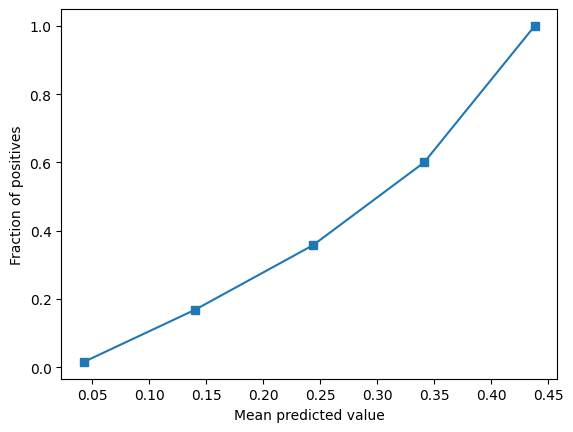

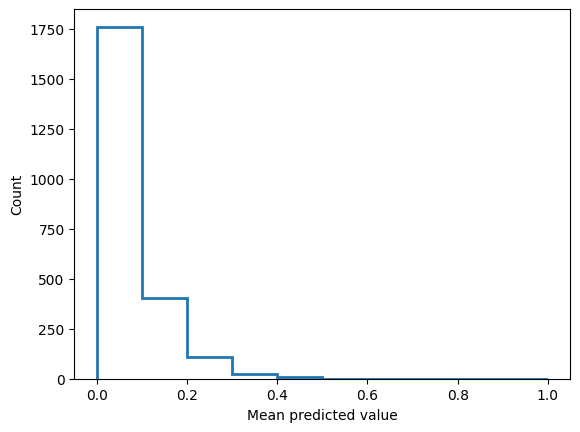

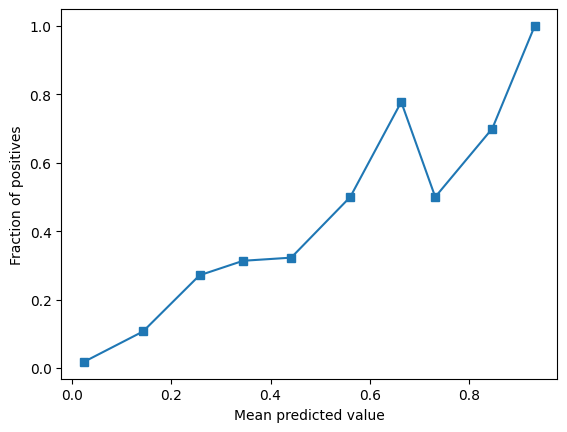

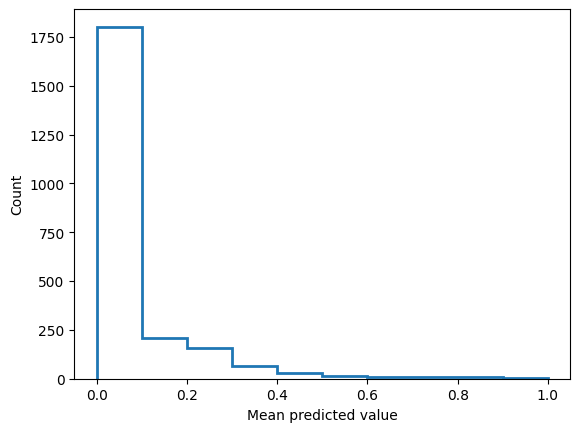

ROC AUC: 0.9005214042364095
Average Precision: 0.4505073216489946
Accuracy: 0.9319462505418292
ROC AUC: 0.9029225299955562
Average Precision: 0.44121216978100386
Accuracy: 0.9380147377546597

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 3374.0

Probability threshold: 0.5
Score threshold: 8826.0

Probability threshold: 0.9
Score threshold: 8826.0

ROC AUC: 0.8615849503777218
Average Precision: 0.3295425752908808


In [14]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)
scores, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

[[ 1.         -0.39828373]
 [-0.39828373  1.        ]]
[[1.         0.77334775]
 [0.77334775 1.        ]]


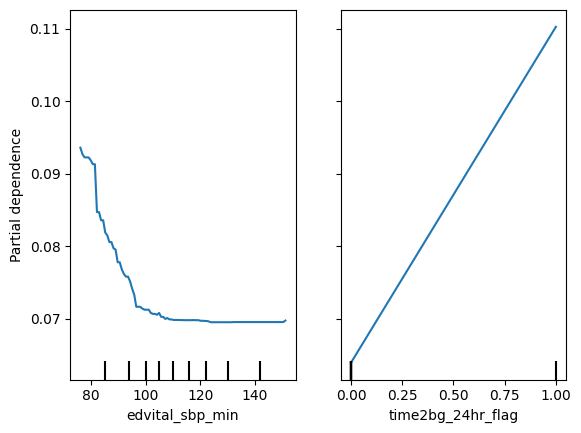

In [15]:
features = np.argpartition(clf.feature_importances_, -2)[-2:]

PartialDependenceDisplay.from_estimator(clf, X_test, features)

print(np.corrcoef(scores, X_test.iloc[:, features[0]]))
print(np.corrcoef(scores, X_test.iloc[:, features[1]]))

##6. Neural Network

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

estimators = [('Scaler', StandardScaler()), 
              ('Neural_Network', MLPClassifier(
                  hidden_layer_sizes=(100),
                  random_state=seed, 
                  activation='logistic', 
                  solver='sgd', 
                  max_iter=1000))]
pipe = Pipeline(estimators)

pipe.fit(X_train, y_train)

y_pred = pipe.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

ROC AUC: 0.9064760776181306
Average Precision: 0.43185200764937204


| Step 1  ==> Calibrating model


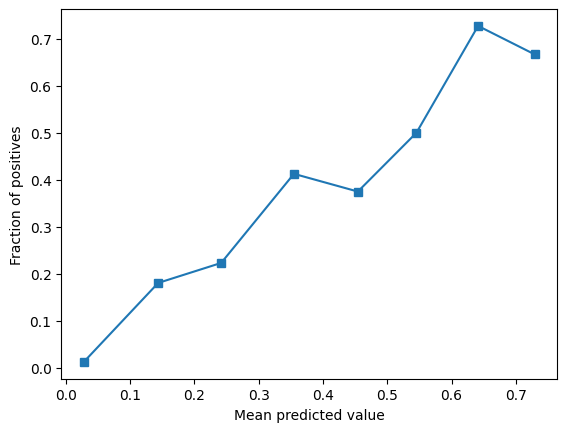

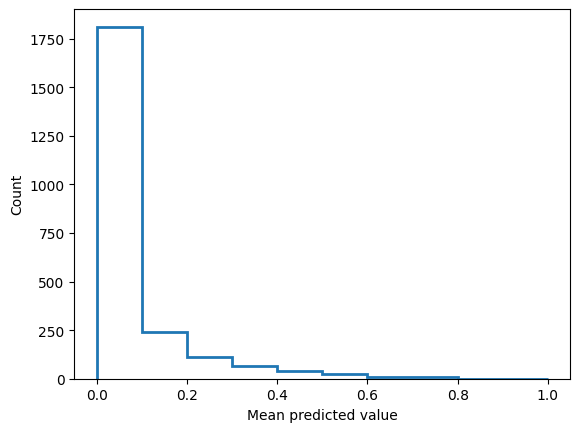

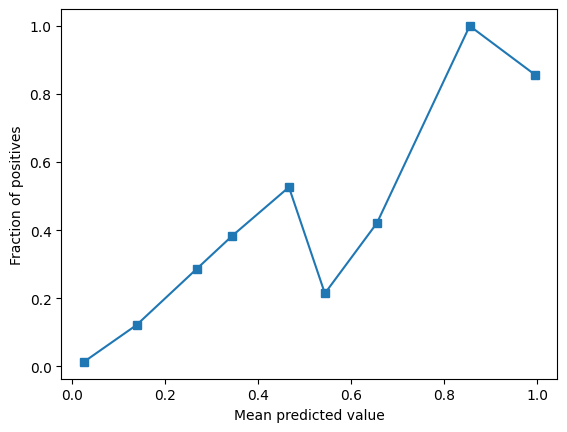

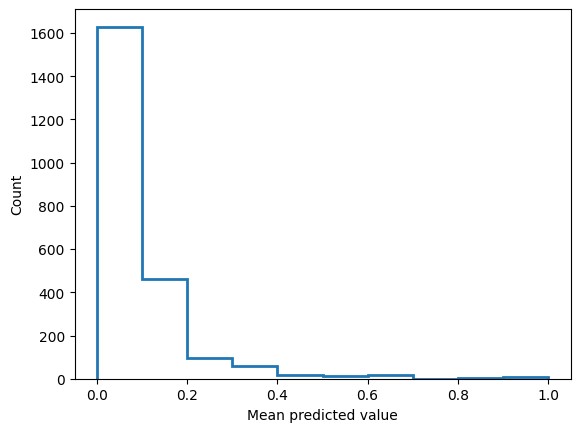

ROC AUC: 0.9064760776181306
Average Precision: 0.43185200764937204
Accuracy: 0.9354139575205895
ROC AUC: 0.8868152866242038
Average Precision: 0.37440332075360105
Accuracy: 0.9306458604247941

| Step 2 ==> Calculate SHAP values


Kernel Explainer Iteration 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Kernel Explainer Iteration 1


  0%|          | 0/1000 [00:00<?, ?it/s]

divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encountered in log
invalid value encountered in divide
divide by zero encou

In [ ]:
explainer = medical_explainer['explainer'](pipe, X_train[:1000], y_train[:1000], X_test, y_test)
explainer.fit(10, shap_method='kernel', method='novel', n_splits=2)

_, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

##7. LightGBM (ablations)

In [23]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [24]:
from lightgbm import LGBMClassifier


parameters = {
    'n_estimators': [160, 180, 200, 220], 
    'max_depth':[1, 3, 5]
}

lgbm = LGBMClassifier(random_state=seed)
clf = GridSearchCV(lgbm, parameters, scoring='roc_auc')
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 1, 'n_estimators': 220}
0.8842145924251188


In [25]:
# Need to do some tuning
clf = LGBMClassifier(n_estimators=220, max_depth=1, random_state=seed)
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

ROC AUC: 0.9013834987409272
Average Precision: 0.4362062988357976


| Step 1  ==> Calibrating model


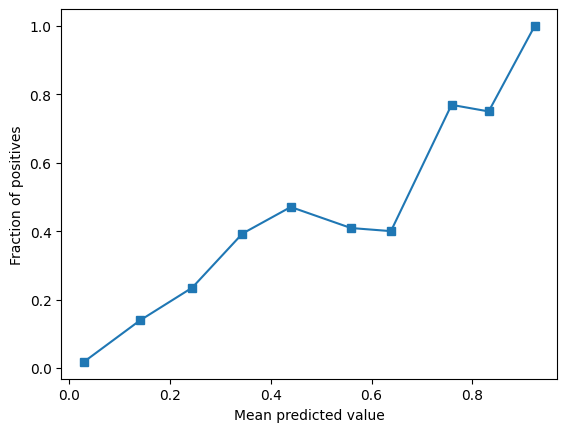

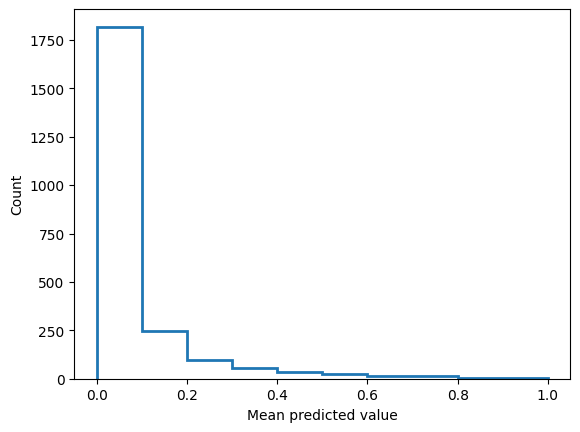

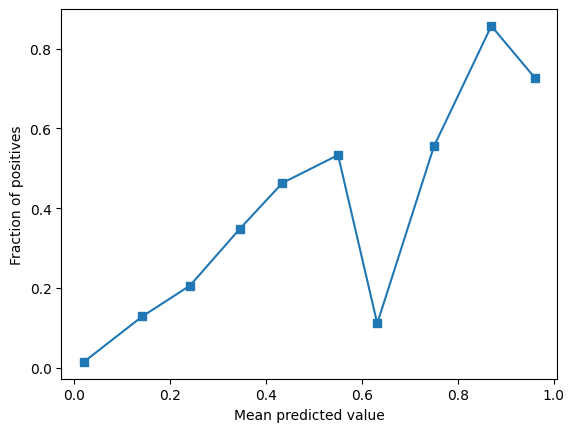

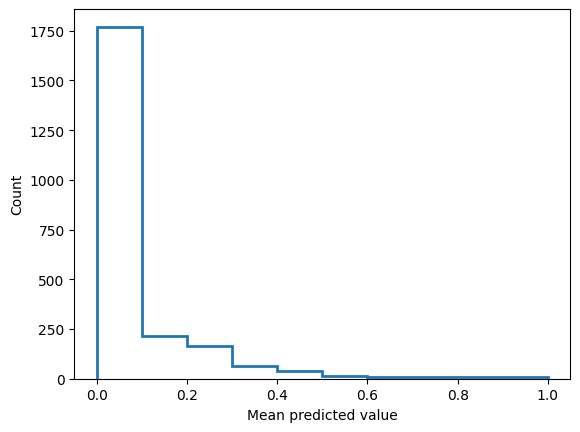

ROC AUC: 0.9013834987409272
Average Precision: 0.4362062988357976
Accuracy: 0.9336801040312094
ROC AUC: 0.90402310768775
Average Precision: 0.43061411339881167
Accuracy: 0.9341135674035544

| Step 2 ==> Calculate SHAP values


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



| Step 3 ==> Fit clinical score calculator
Novel fitting


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


ValueError: ignored

In [26]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.000001)
_, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

##8. CatBoost

In [27]:
# Need to do some tuning
from catboost import CatBoostClassifier

clf = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)

clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

performance(y_test, y_pred)

0:	learn: 0.2470684	total: 67.7ms	remaining: 67.7ms
1:	learn: 0.2115273	total: 75.4ms	remaining: 0us
ROC AUC: 0.793784624500074
Average Precision: 0.21721605007475414


| Step 1  ==> Calibrating model


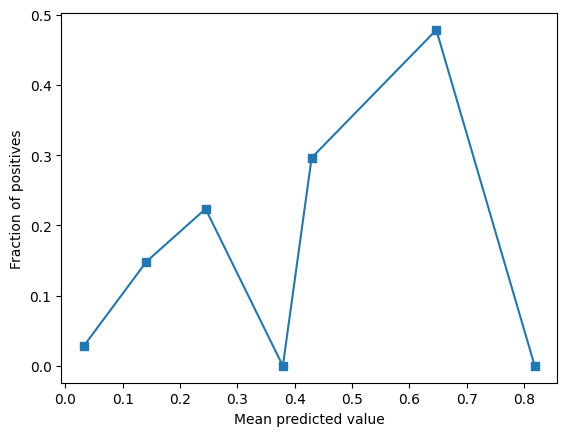

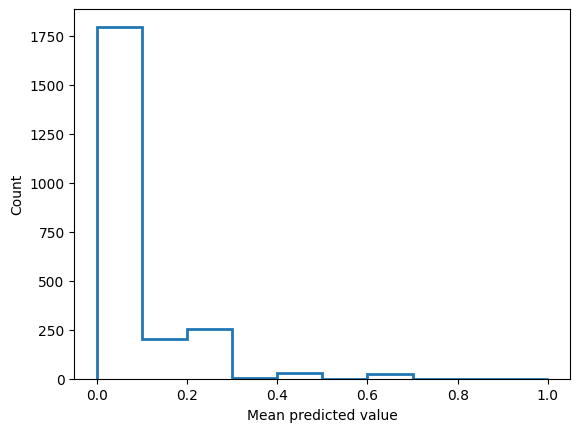

0:	learn: 0.2467061	total: 3.31ms	remaining: 3.31ms
1:	learn: 0.2192058	total: 6.5ms	remaining: 0us
0:	learn: 0.2495735	total: 4.51ms	remaining: 4.51ms
1:	learn: 0.2130089	total: 11.8ms	remaining: 0us
0:	learn: 0.2487553	total: 3.18ms	remaining: 3.18ms
1:	learn: 0.2122622	total: 5.6ms	remaining: 0us
0:	learn: 0.2461285	total: 7.82ms	remaining: 7.82ms
1:	learn: 0.2119975	total: 11ms	remaining: 0us
0:	learn: 0.2513505	total: 8.01ms	remaining: 8.01ms
1:	learn: 0.2115085	total: 13.5ms	remaining: 0us


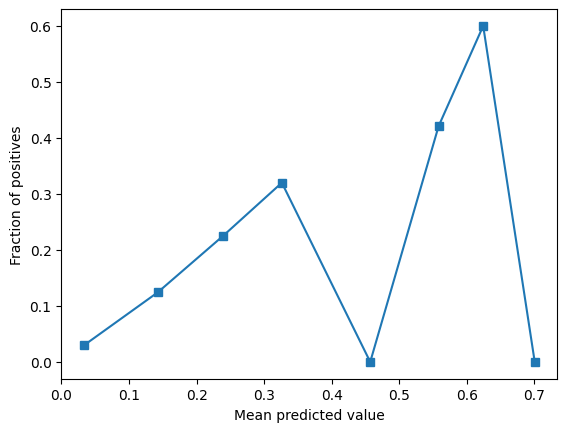

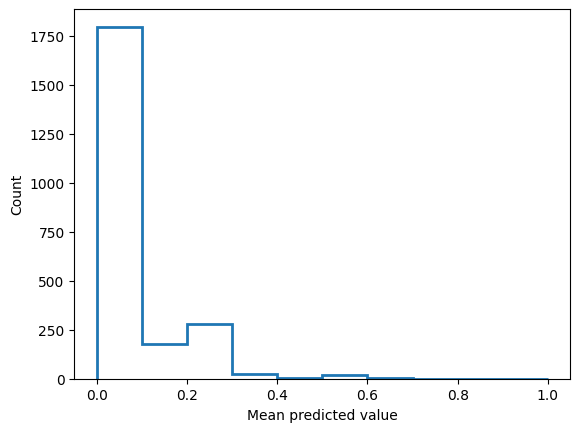

ROC AUC: 0.793784624500074
Average Precision: 0.21721605007475414
Accuracy: 0.9310793237971391
ROC AUC: 0.8041030958376537
Average Precision: 0.2350862290532187
Accuracy: 0.9306458604247941

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


ValueError: ignored

In [28]:
explainer = medical_explainer['explainer'](clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel', calculator_threshold=0.0001)
_, probs, _ = explainer.predict_calculator(X_test, 1)

performance(y_test, probs)

#References

> Anthony Li, Ming Lun Ong, Chien Wei Oei, Weixiang
Lian, Hwee Pin Phua, Lin Htun Htet, and Wei Yen
Lim. 2022. Unified auto clinical scoring (Uni-ACS)
with interpretable ml models. In Machine Learning
for Healthcare Conference, pages 26–53. PMLR.


